# MLlib - machine learning in spark


## In this Noteboook
1. create a context
2. work with s3 and parquet to make our data frame
3. work with MLlib on the data frame

In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

# Initialize the spark environment (takes ~ 1min)

In [2]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
sqlc

## Connect to S3
There are a few ways to connect to S3, we are going to use boto
* boto3 - https://boto3.amazonaws.com/v1/documentation/api/latest/index.html

### Read into spark dataframe from csv in s3

In [4]:
#role = get_execution_role()
bucket='odl-spark19spds6003-001/sam8sp'
data_key = 'kc_house_data.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [5]:
df = sqlc.createDataFrame(pd.read_csv(data_location))
df

DataFrame[id: bigint, date: string, price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, zipcode: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

### Write parquet to s3

In [6]:
# Commenting out due to error caused by rerunning
parquetPath = '/home/ec2-user/SageMaker/sam8sp/tmp-pqt2'
# df.write.parquet(parquetPath)

In [7]:
s3 = boto3.client('s3')
response = s3.list_buckets()
buckets = [bucket['Name'] for bucket in response['Buckets']]
print("Bucket List: %s" % buckets)

Bucket List: ['2017-2018-capstone-plos', '846033058400-dlt-utilization', 'odl-bamc', 'odl-bamc-scratch', 'odl-cbwc', 'odl-domi', 'odl-hmtt', 'odl-hmtt-scratch', 'odl-nept', 'odl-orci', 'odl-pmis', 'odl-podc', 'odl-projects-test', 'odl-readonly-test', 'odl-scratch-test', 'odl-spark-education', 'odl-spark19spds6003-001', 'odl-watr', 'odl-watr-scratch', 'odl-wiki', 'uva-bucket']


In [8]:
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]
files

['part-00000-70cddae6-8503-49d0-95c0-2a25c463b265-c000.snappy.parquet',
 '._SUCCESS.crc',
 '.part-00000-70cddae6-8503-49d0-95c0-2a25c463b265-c000.snappy.parquet.crc',
 '_SUCCESS']

In [9]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

# bucket = bucket + '/'
# bucket

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket('odl-spark19spds6003-001').upload_file(parquetPath+'/'+f, "sam8sp/"+f)


### Write to spark dataframe from parquet

In [10]:
df = sqlc.read.parquet(parquetPath)

In [11]:
df

DataFrame[id: bigint, date: string, price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, zipcode: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

# Now to start our ML pipeline

In [12]:
display(df)

DataFrame[id: bigint, date: string, price: double, bedrooms: bigint, bathrooms: double, sqft_living: bigint, sqft_lot: bigint, floors: double, waterfront: bigint, view: bigint, condition: bigint, grade: bigint, sqft_above: bigint, sqft_basement: bigint, yr_built: bigint, yr_renovated: bigint, zipcode: bigint, lat: double, long: double, sqft_living15: bigint, sqft_lot15: bigint]

In [13]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- price: double (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: long (nullable = true)
 |-- sqft_lot: long (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: long (nullable = true)
 |-- view: long (nullable = true)
 |-- condition: long (nullable = true)
 |-- grade: long (nullable = true)
 |-- sqft_above: long (nullable = true)
 |-- sqft_basement: long (nullable = true)
 |-- yr_built: long (nullable = true)
 |-- yr_renovated: long (nullable = true)
 |-- zipcode: long (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- sqft_living15: long (nullable = true)
 |-- sqft_lot15: long (nullable = true)



In [14]:
df.take(5)

[Row(id=7129300520, date='20141013T000000', price=221900.0, bedrooms=3, bathrooms=1.0, sqft_living=1180, sqft_lot=5650, floors=1.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=1180, sqft_basement=0, yr_built=1955, yr_renovated=0, zipcode=98178, lat=47.5112, long=-122.257, sqft_living15=1340, sqft_lot15=5650),
 Row(id=6414100192, date='20141209T000000', price=538000.0, bedrooms=3, bathrooms=2.25, sqft_living=2570, sqft_lot=7242, floors=2.0, waterfront=0, view=0, condition=3, grade=7, sqft_above=2170, sqft_basement=400, yr_built=1951, yr_renovated=1991, zipcode=98125, lat=47.721000000000004, long=-122.319, sqft_living15=1690, sqft_lot15=7639),
 Row(id=5631500400, date='20150225T000000', price=180000.0, bedrooms=2, bathrooms=1.0, sqft_living=770, sqft_lot=10000, floors=1.0, waterfront=0, view=0, condition=3, grade=6, sqft_above=770, sqft_basement=0, yr_built=1933, yr_renovated=0, zipcode=98028, lat=47.7379, long=-122.23299999999999, sqft_living15=2720, sqft_lot15=8062),
 Row(id

## Finally, ML time 
1. **SPARK SPECIAL SAUCE** -  pysparki.ml.linalg - vectorization
2. split data into train/test
3. Train --> Predict --> Evaluate

# VECTORIZATION - spark special sauce

In [15]:
from pyspark.ml.linalg import Vectors, VectorUDT # nb: bad form, done for pedagogy
from pyspark.ml.feature import VectorAssembler

In [16]:
assembler = VectorAssembler(
    inputCols=['sqft_living','sqft_lot','sqft_above','sqft_basement'],
    outputCol='features')
df = df.withColumnRenamed('price','label')
lr_df = assembler.transform(df)
lr_df = lr_df.select(['features','label'])
lr_df.take(5)

[Row(features=DenseVector([1180.0, 5650.0, 1180.0, 0.0]), label=221900.0),
 Row(features=DenseVector([2570.0, 7242.0, 2170.0, 400.0]), label=538000.0),
 Row(features=DenseVector([770.0, 10000.0, 770.0, 0.0]), label=180000.0),
 Row(features=DenseVector([1960.0, 5000.0, 1050.0, 910.0]), label=604000.0),
 Row(features=DenseVector([1680.0, 8080.0, 1680.0, 0.0]), label=510000.0)]

## Make training and testing sets

In [17]:
seed = 88
(testDF,trainingDF) = lr_df.randomSplit([0.2,0.8], seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 17261, test set N = 4352


## ML time for real
1. Train
2. Predict
3. Evaluate

In [18]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [19]:
type(lrModel)

pyspark.ml.regression.LinearRegressionModel

We are now going to transform our test set to get predictions. It will append a prediction column to testDF in the new dataframe predictionsAndLabelsDF.

In [20]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(features=DenseVector([9890.0, 31374.0, 8860.0, 1030.0]), label=6885000.0, prediction=2727276.8658586787), Row(features=DenseVector([5020.0, 12431.0, 3420.0, 1600.0]), label=3600000.0, prediction=1387777.2013430106), Row(features=DenseVector([4850.0, 10584.0, 3540.0, 1310.0]), label=3567000.0, prediction=1334730.489247836), Row(features=DenseVector([4260.0, 11765.0, 3280.0, 980.0]), label=3400000.0, prediction=1162885.3531400468), Row(features=DenseVector([4220.0, 41300.0, 2460.0, 1760.0]), label=3300000.0, prediction=1159774.1723325874)]


## Model Evaluation

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [22]:
type(eval)

pyspark.ml.evaluation.RegressionEvaluator

In [23]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

257793.82837278114

In [24]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.48034397985275146

## Visualize Residuals

In [25]:
from matplotlib import pyplot

In [26]:
trainingSummary = lrModel.summary
pd_res = trainingSummary.residuals.toPandas()
pd_pred = trainingSummary.predictions.toPandas()

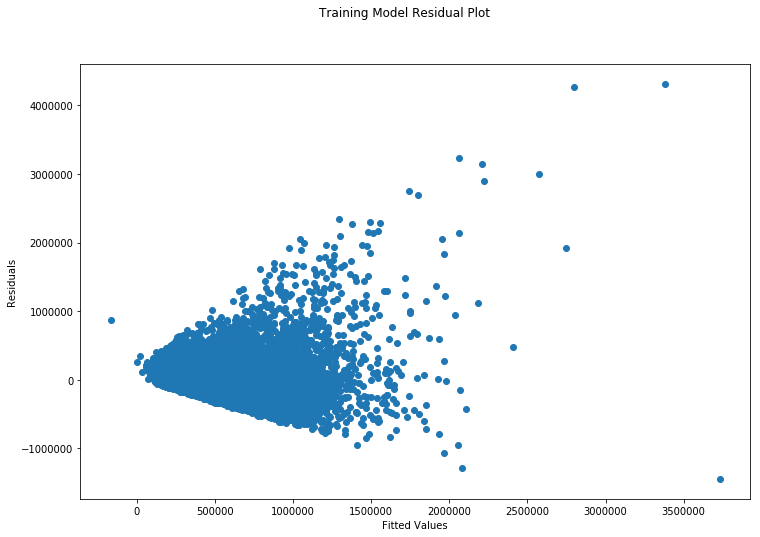

In [36]:
fig = pyplot.figure()
fig.suptitle('Training Model Residual Plot')
pyplot.rcParams["figure.figsize"] = [9.0,6.0]
pyplot.xlabel('Fitted Values')
pyplot.ylabel('Residuals')
pyplot.scatter(pd_pred.prediction,pd_res)